In [1]:
import numpy as np
import json
import os
import pandas as pd
from matplotlib import pyplot as plt
import sys
from scipy import stats
import sklearn
import seaborn as sb
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
import itertools
import mne
from mne.decoding import CSP
from mne import Epochs
from mne.decoding import SPoC
mne.set_log_level(verbose='warning') #to avoid info at terminal
import pickle 
import sys
# insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(1, '/home/victoria/icn/icn_m1')
import os

from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet


from scipy import stats
from collections import OrderedDict
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from bayes_opt import BayesianOptimization
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
import gc
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBRegressor

space_LM = [Real(0, 1, "uniform", name='alpha'),Real(0, 1, "uniform", name='l1_ratio')]

def optimize_enet(x,y):
    scaler = StandardScaler()
    reg=ElasticNet(max_iter=1000)
    clf = make_pipeline(scaler, reg)

      
    @use_named_args(space_LM)
    def objective(**params):
        reg.set_params(**params)
        cval = cross_val_score(clf, x, y, scoring='r2', cv=3)
        cval[np.where(cval < 0)[0]] = 0
    
        return -cval.mean()

    res_gp = gp_minimize(objective, space_LM, n_calls=20, random_state=0)
    return res_gp


In [2]:
# subjects to analyze
subjects = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']
PATH_BASE = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\ECoG_STN\\"

In [3]:
def set_box_color(bp, color):
    #plt.setp(bp['boxes'], color='black')
    #plt.setp(bp['whiskers'], color='black')
    #plt.setp(bp['caps'], color='black')
    plt.setp(bp['medians'], color='black')
    l_ = []
    l_.append(color)
    l_ = l_*len(bp['boxes']) 
    for patch, color_ in zip(bp['boxes'], l_):
        patch.set_facecolor(color_)
    
def my_box_plot_comparison_here(data_a, data_b, label_1='contralateral', label_2='ipsilateral'):
    ran = len(data_a)
    ticks = [str(i) for i in range(ran)]
    bpl = plt.boxplot(data_a, positions=np.array(range(ran))*2.0-0.4, showmeans=True, widths=0.45, patch_artist=True)
    bpr = plt.boxplot(data_b, positions=np.array(range(ran))*2.0+0.4, showmeans=True,widths=0.45, patch_artist=True)
    set_box_color(bpl, 'red') # colors are from http://colorbrewer2.org/
    set_box_color(bpr, 'blue')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='red', label=label_1)
    plt.plot([], c='blue', label=label_2)

    plt.xlim(-2, len(ticks)*2)
    plt.tight_layout()
    #plt.xticks(range(0, len(ticks) * 2, 2), ['LM', 'NN', 'SPOC t-lag', 'XGB '+r'$\beta$'+ r'$\gamma$', 'XGB'], rotation=90)
    plt.xticks(range(0, len(ticks) * 2, 2), ['LM', 'SPOC LM', 'SPOC_XGB','XGB'], rotation=90)
    plt.ylabel(r'$R^2$')
    plt.ylim(-0.1, 0.9)
    plt.legend(loc='upper left')
    

In [4]:
def get_res(PATH_, all_=True, best_Tr=False, SPOC_ = False, log_=False):
    """
    Given the resp. Path for LM/XGB/NN based on single channel estimaton; 
    return rather all, oder just the best CV test or test(best train) performances 
    returns dict(ECOG CON, ECOG IPS; STN CON, STN IPS)
    """
    res_files = os.listdir(PATH_)
    res_ = {}; # ECOG CON, ECOG IPS; STN CON, STN IPS
    for loc in ["ECOG", "STN"]:
        for lat in ["CON", "IPS"]:
            patients_ = []
            for sub in subjects:
                files = [f for f in res_files if (sub in f) and (loc in f)]
                max_ = []; tr_ = []; te_ = []
                for file in files: # Sess right or left
                    
                    if log_ is True: print(file)
                    if all_ is True:
                        max_.append(np.load(os.path.join(PATH_, file), 
                                               allow_pickle=True).tolist()["score_te"][lat])
                    else:
                        if SPOC_ is False:
                            max_.append(np.max(np.load(os.path.join(PATH_, file), 
                                               allow_pickle=True).tolist()["score_te"][lat]))
                            tr_.append(np.load(os.path.join(PATH_, file), allow_pickle=True).tolist()["score_tr"][lat])
                            te_.append(np.load(os.path.join(PATH_, file), allow_pickle=True).tolist()["score_te"][lat])

                        else:
                            max_.append(np.mean(np.load(os.path.join(PATH_, file), 
                                               allow_pickle=True).tolist()["score_te"][lat]))
                            tr_.append(np.mean(np.load(os.path.join(PATH_, file), allow_pickle=True).tolist()["score_tr"][lat]))
                            te_.append(np.mean(np.load(os.path.join(PATH_, file), allow_pickle=True).tolist()["score_te"][lat]))

                if all_ is True: 
                    patients_.append(np.concatenate(max_).ravel())
                else:
                    if best_Tr is True:
                        if SPOC_ is False:
                            patients_.append(np.concatenate(te_).ravel()[np.argmax(np.concatenate(tr_).ravel())])
                        else:
                            patients_.append(np.ravel(te_)[np.argmax(np.ravel(tr_))])
                    else:
                        patients_.append(np.max(max_))
            res_[loc+"_"+lat] = np.concatenate(patients_).ravel() if all_ is True else patients_
    return res_

In [5]:
res_XGB =  get_res(os.path.join(PATH_BASE, "XGB_Out"), all_=True, best_Tr=False, log_=False, SPOC_=False)
res_LM =  get_res(os.path.join(PATH_BASE, "LM_Out"), all_=True, best_Tr=False, log_=False, SPOC_=False)
res_SPOC_LM = get_res(os.path.join(PATH_BASE, "LM_Out_SPoC"), all_=True, best_Tr=False, log_=False, SPOC_=True)
res_SPOC_XGB = get_res(os.path.join(PATH_BASE, "XGB_Out_SPoC"), all_=True, best_Tr=False, log_=False, SPOC_=True)


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator ElasticNet from version 0.23.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-o

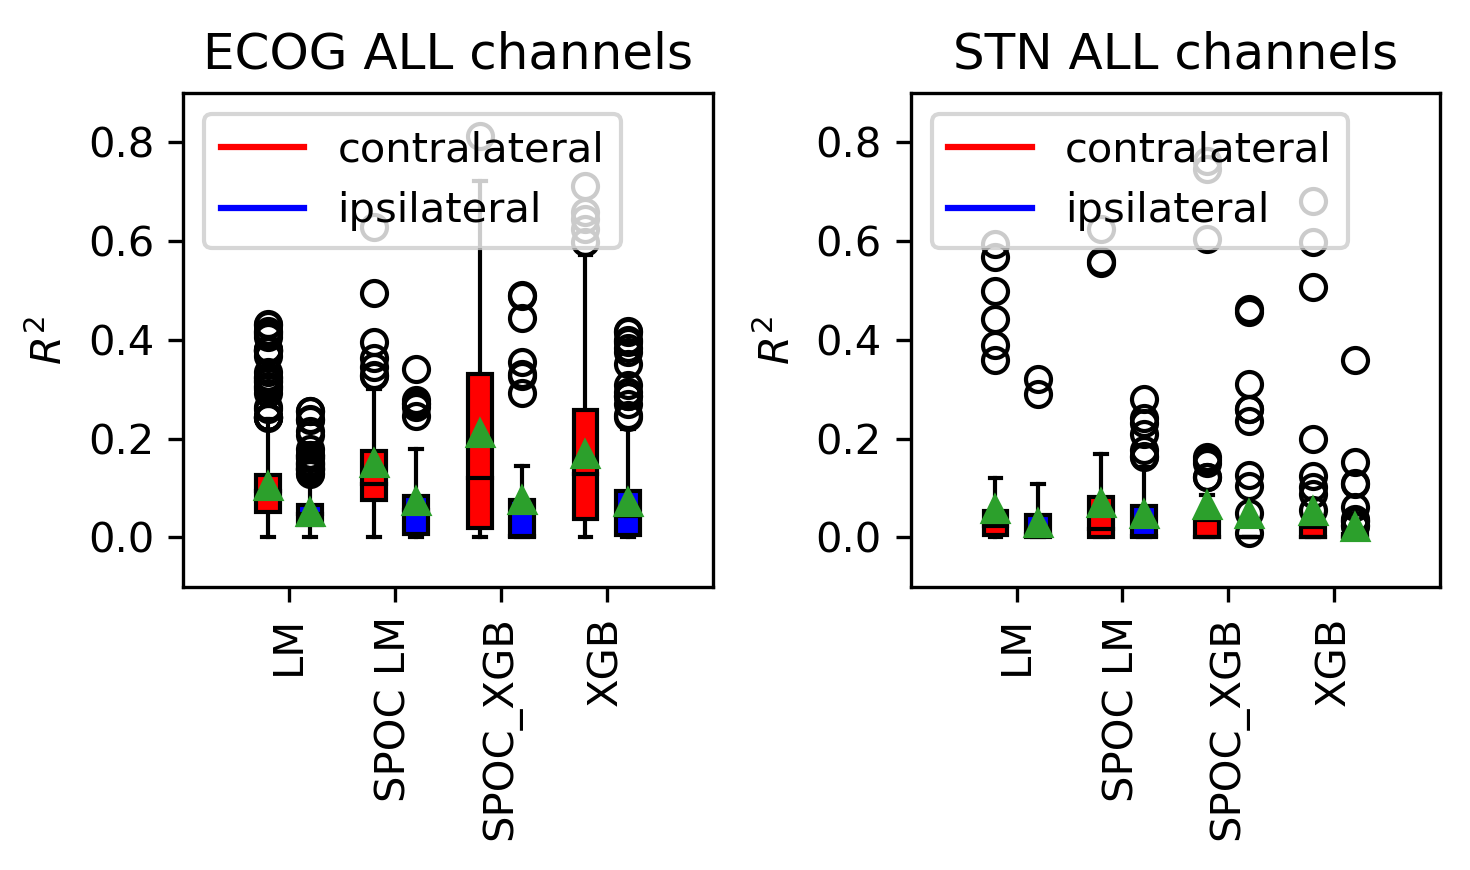

In [7]:
plt.figure(figsize=(5,3), dpi=300)
plt.subplot(121)
plt.title('ECOG ALL channels')
my_box_plot_comparison_here([res_LM["ECOG_CON"], res_SPOC_LM["ECOG_CON"], res_SPOC_XGB["ECOG_CON"], res_XGB["ECOG_CON"]], \
                            [res_LM["ECOG_IPS"], res_SPOC_LM["ECOG_IPS"], res_SPOC_XGB["ECOG_IPS"], res_XGB["ECOG_IPS"]], \
                            label_1='contralateral', label_2='ipsilateral')

plt.subplot(122)
plt.title('STN ALL channels')
my_box_plot_comparison_here([res_LM["STN_CON"], res_SPOC_LM["STN_CON"], res_SPOC_XGB["STN_CON"], res_XGB["STN_CON"]], \
                            [res_LM["STN_IPS"], res_SPOC_LM["STN_IPS"], res_SPOC_XGB["STN_IPS"], res_XGB["STN_IPS"]], \
                            label_1='contralateral', label_2='ipsilateral')
plt.ylabel(r'$R^2$')
plt.tight_layout()

### get data from trained NN

In [5]:
import math

In [6]:
PATH = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\MOVEMENT DATA\\ECoG_STN\\NN_Out_NOCV\\"
patients = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']

In [7]:
res_here = []
for loc in ["ECOG", "STN"]:
    for lat in ["CON", "IPS"]:
        sc_p = []
        for sub in patients:
            sc_ = []
            files = [f for f in os.listdir(PATH) if sub in f and lat in f and loc in f]
            for f in files:
                res = np.load(os.path.join(PATH, f), allow_pickle=True)
                try:
                    if math.isnan(res.tolist()["score_te"]):
                        sc_.append(0)
                    else:
                        sc_.append(res.tolist()["score_te"])
                except:
                    sc_.append(0)
            try:
                sc_p.append(np.max(sc_))
            except:
                sc_p.append(0)
        res_here.append(sc_p)

In [8]:
res_NN = {
    "ECOG_CON": res_here[0],
    "ECOG_IPS": res_here[1],
    "STN_CON": res_here[2],
    "STN_IPS": res_here[3]
}

In [9]:
from sklearn import linear_model
from sklearn.linear_model import coordinate_descent

C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.linear_model.coordinate_descent module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator ElasticNet from version 0.23.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


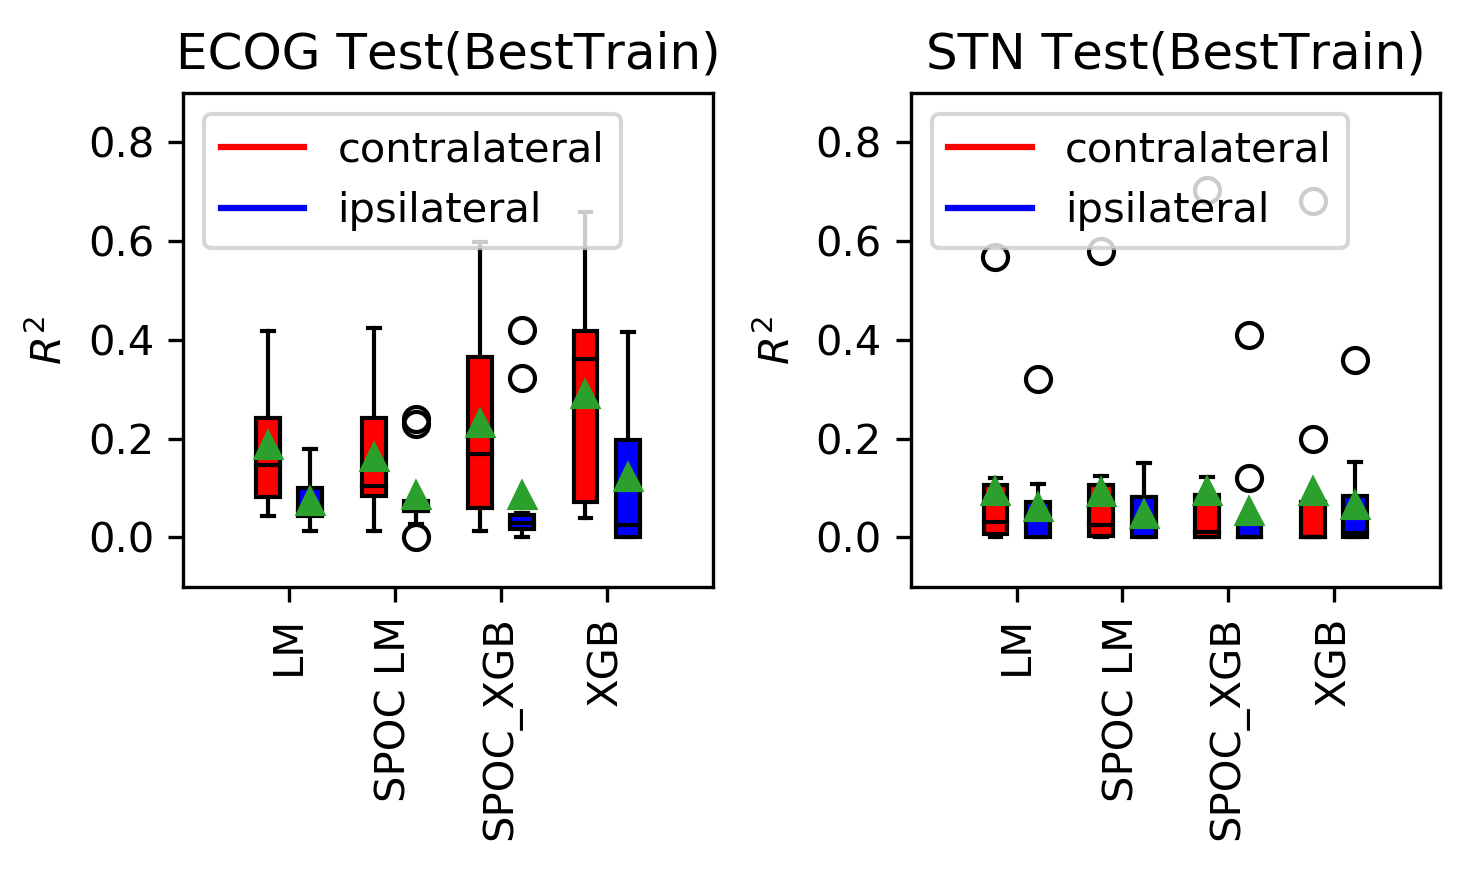

In [12]:
res_XGB =  get_res(os.path.join(PATH_BASE, "XGB_Out"), all_=False, best_Tr=True, log_=False, SPOC_=False)
res_LM =  get_res(os.path.join(PATH_BASE, "LM_Out"), all_=False, best_Tr=True, log_=False, SPOC_=False)
res_SPOC_LM = get_res(os.path.join(PATH_BASE, "LM_Out_SPoC"), all_=False, best_Tr=True, log_=False, SPOC_=True)
res_SPOC_XGB = get_res(os.path.join(PATH_BASE, "XGB_Out_SPoC"), all_=False, best_Tr=True, log_=False, SPOC_=True)

plt.figure(figsize=(5,3), dpi=300)
plt.subplot(121)
plt.title('ECOG Test(BestTrain)')
my_box_plot_comparison_here([res_LM["ECOG_CON"], res_SPOC_LM["ECOG_CON"], res_SPOC_XGB["ECOG_CON"], res_XGB["ECOG_CON"]], \
                            [res_LM["ECOG_IPS"], res_SPOC_LM["ECOG_IPS"], res_SPOC_XGB["ECOG_IPS"], res_XGB["ECOG_IPS"]], \
                            label_1='contralateral', label_2='ipsilateral')

plt.subplot(122)
plt.title('STN Test(BestTrain)')
my_box_plot_comparison_here([res_LM["STN_CON"], res_SPOC_LM["STN_CON"], res_SPOC_XGB["STN_CON"], res_XGB["STN_CON"]], \
                            [res_LM["STN_IPS"], res_SPOC_LM["STN_IPS"], res_SPOC_XGB["STN_IPS"], res_XGB["STN_IPS"]], \
                            label_1='contralateral', label_2='ipsilateral')
plt.ylabel(r'$R^2$')
plt.tight_layout()

In [20]:
np.mean(np.array(res_XGB["ECOG_CON"]) - np.array(res_XGB["STN_CON"]))
np.std(np.array(res_XGB["ECOG_CON"]) - np.array(res_XGB["STN_CON"]))
np.array(res_XGB["ECOG_CON"]) - np.array(res_XGB["STN_CON"])

0.19662790799714971

### try out Seaborn strip plot

In [13]:
import seaborn as sb
import pandas as pd

In [14]:
# hue = lat
# x = method 
# y = performance 
# add. column: loc: ECOG STN 
df = pd.DataFrame()
subjects = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']
for meth_ in ["ECOG_CON", "ECOG_IPS", "STN_CON", "STN_IPS"]:
    if "ECOG" in meth_:
        loc = "ECOG"
    else:
        loc = "STN"
    if "CON" in meth_:
        lat = "CON"
    else:
        lat = "IPS"
    for sub_idx, sub in enumerate(subjects):
        df = df.append({r"$R^2$":res_XGB[meth_][sub_idx],"sub":sub,"loc":loc,"lat":lat,"method":"XGB"}, ignore_index=True)
        df = df.append({r"$R^2$":res_SPOC_XGB[meth_][sub_idx],"sub":sub,"loc":loc,"lat":lat,"method":"SPOC_XGB"}, ignore_index=True)
        df = df.append({r"$R^2$":res_SPOC_LM[meth_][sub_idx],"sub":sub,"loc":loc,"lat":lat,"method":"SPOC_LM"}, ignore_index=True)
        df = df.append({r"$R^2$":res_LM[meth_][sub_idx],"sub":sub,"loc":loc,"lat":lat,"method":"LM"}, ignore_index=True)
        df = df.append({r"$R^2$":res_NN[meth_][sub_idx],"sub":sub,"loc":loc,"lat":lat,"method":"NN"}, ignore_index=True)

In [15]:
df.to_pickle("test_best_train.p")

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

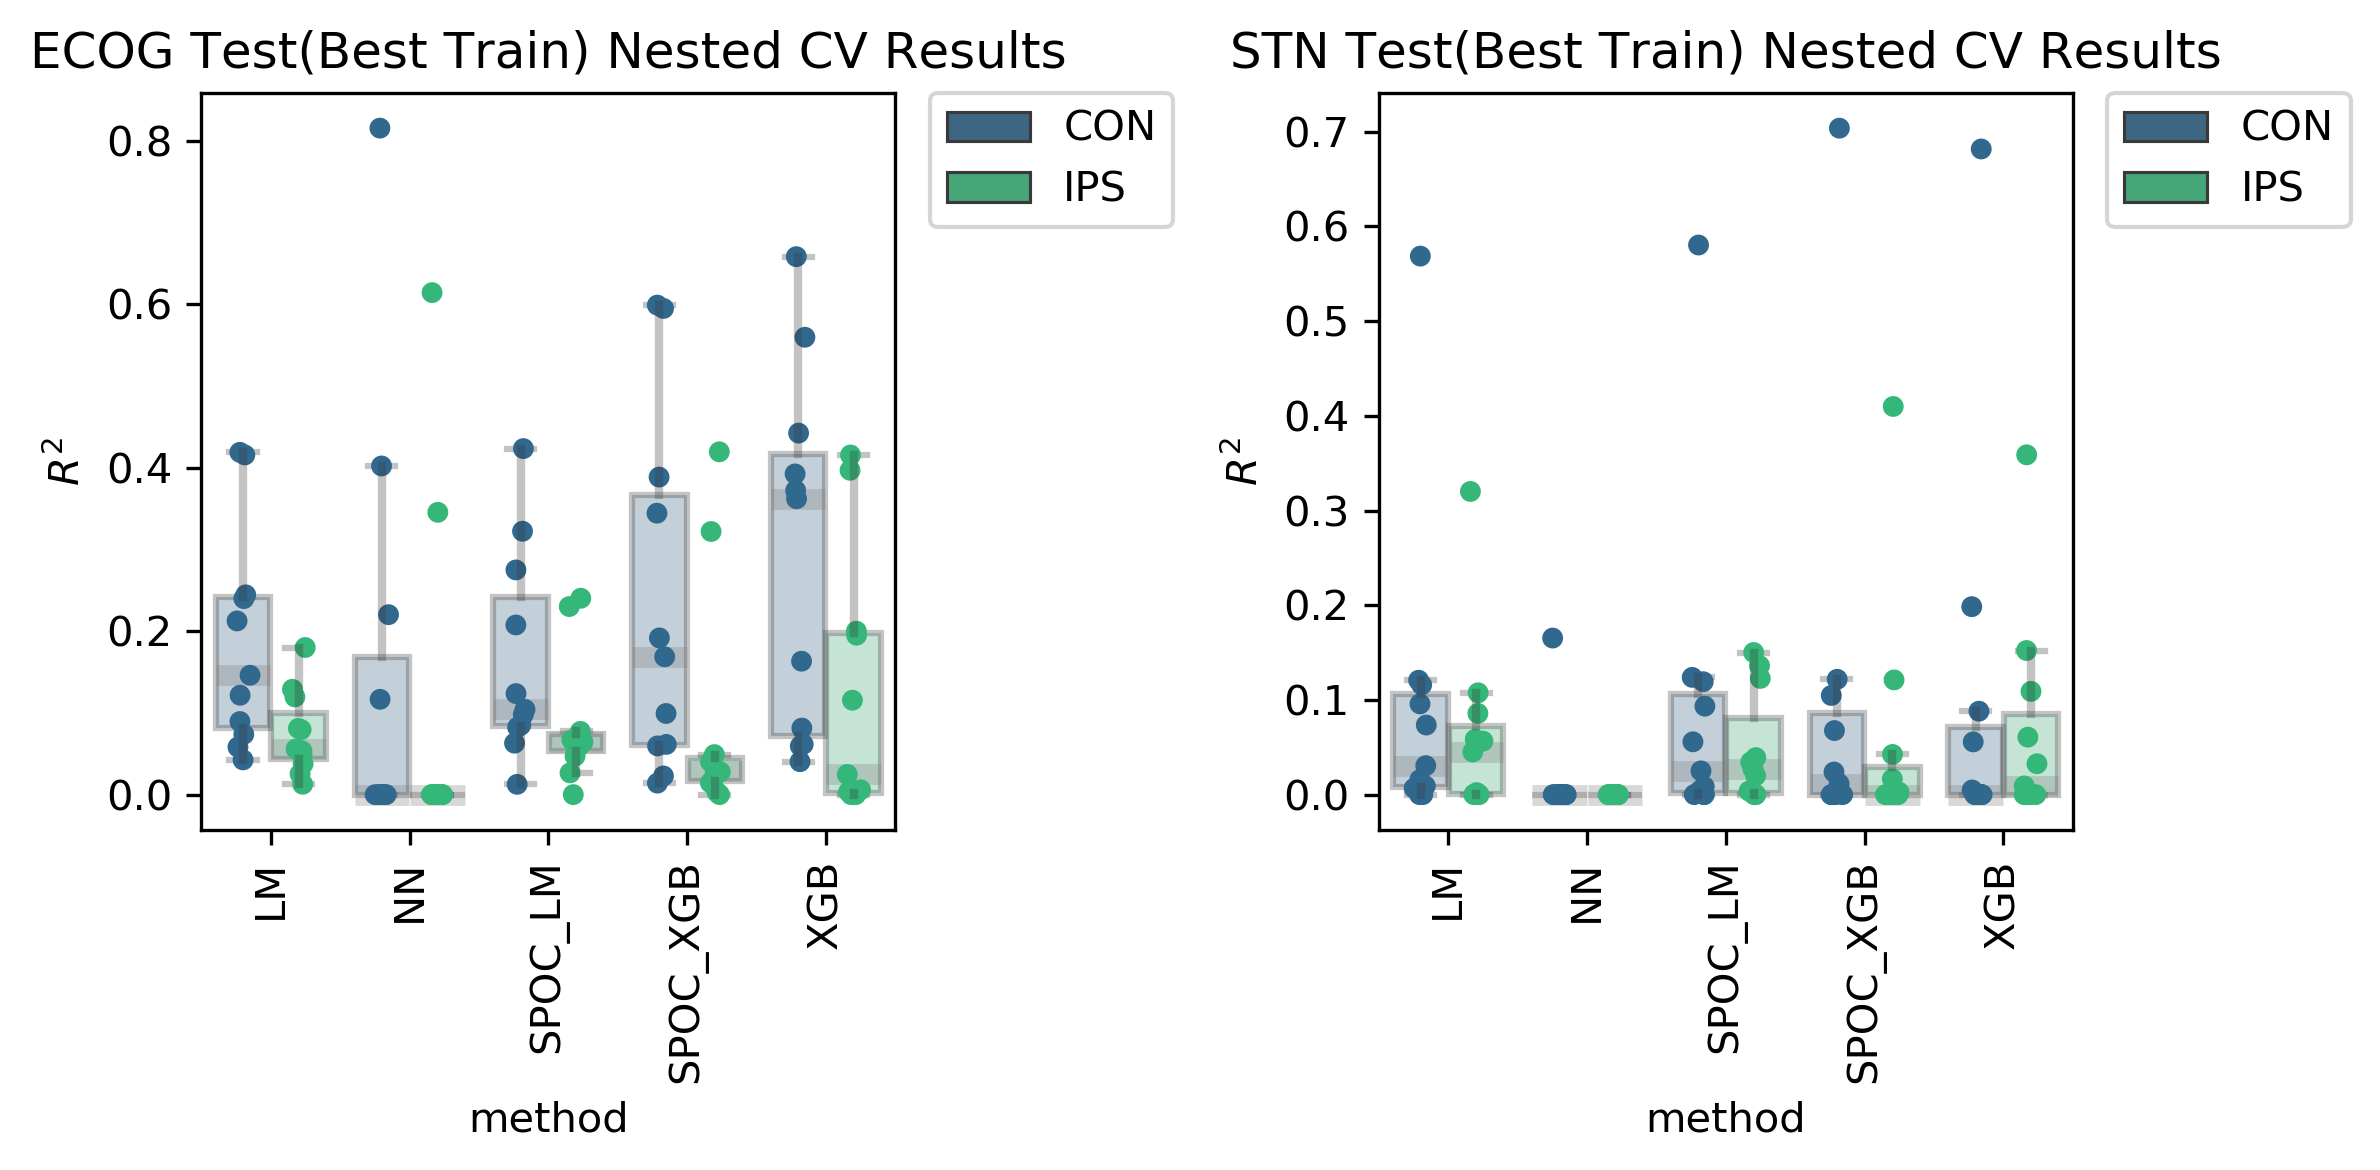

In [16]:
alpha_box = 0.3
plt.figure(figsize=(8,4), dpi=300)
plt.subplot(121)
sb.boxplot(x="method", y=r"$R^2$", hue="lat", order=["LM", "NN", "SPOC_LM", "SPOC_XGB","XGB"], 
           data=df[df["loc"] == "ECOG"], palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=5, color="gray", alpha=alpha_box))

    
ax = sb.stripplot(x="method", y=r"$R^2$", hue="lat", order=["LM", "NN", "SPOC_LM", "SPOC_XGB","XGB"], 
             data=df[df["loc"] == "ECOG"],palette="viridis", dodge=True, s=5)
plt.xticks(rotation=90)

# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("ECOG Test(Best Train) Nested CV Results")
plt.subplot(122)
sb.boxplot(x="method", y=r"$R^2$", hue="lat", order=["LM", "NN", "SPOC_LM", "SPOC_XGB","XGB"], 
           data=df[df["loc"] == "STN"], palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=5, color="gray", alpha=alpha_box))
    
ax = sb.stripplot(x="method", y=r"$R^2$", hue="lat", order=["LM", "NN", "SPOC_LM", "SPOC_XGB","XGB"], 
             data=df[df["loc"] == "STN"],palette="viridis", dodge=True, s=5)


# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("STN Test(Best Train) Nested CV Results")

plt.tight_layout()
plt.xticks(rotation=90)

### Best Test

In [24]:
res_XGB =  get_res(os.path.join(PATH_BASE, "XGB_Out"), all_=False, best_Tr=False, log_=False, SPOC_=False)
res_LM =  get_res(os.path.join(PATH_BASE, "LM_Out"), all_=False, best_Tr=False, log_=False, SPOC_=False)
res_SPOC_LM = get_res(os.path.join(PATH_BASE, "LM_Out_SPoC"), all_=False, best_Tr=False, log_=False, SPOC_=True)
res_SPOC_XGB = get_res(os.path.join(PATH_BASE, "XGB_Out_SPoC"), all_=False, best_Tr=False, log_=False, SPOC_=True)


C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator ElasticNet from version 0.23.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [25]:
# hue = lat
# x = method 
# y = performance 
# add. column: loc: ECOG STN 
df = pd.DataFrame()
subjects = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']
for meth_ in ["ECOG_CON", "ECOG_IPS", "STN_CON", "STN_IPS"]:
    if "ECOG" in meth_:
        loc = "ECOG"
    else:
        loc = "STN"
    if "CON" in meth_:
        lat = "CON"
    else:
        lat = "IPS"
    for sub_idx, sub in enumerate(subjects):
        df = df.append({r"$R^2$":res_XGB[meth_][sub_idx],"sub":sub,"loc":loc,"lat":lat,"method":"XGB"}, ignore_index=True)
        df = df.append({r"$R^2$":res_SPOC_XGB[meth_][sub_idx],"sub":sub,"loc":loc,"lat":lat,"method":"SPOC_XGB"}, ignore_index=True)
        df = df.append({r"$R^2$":res_SPOC_LM[meth_][sub_idx],"sub":sub,"loc":loc,"lat":lat,"method":"SPOC_LM"}, ignore_index=True)
        df = df.append({r"$R^2$":res_LM[meth_][sub_idx],"sub":sub,"loc":loc,"lat":lat,"method":"LM"}, ignore_index=True)
        df = df.append({r"$R^2$":res_NN[meth_][sub_idx],"sub":sub,"loc":loc,"lat":lat,"method":"NN"}, ignore_index=True)

In [28]:
np.mean(np.array(res_XGB["ECOG_CON"]) - np.array(res_XGB["STN_CON"]))

0.21182187457417243

In [29]:
np.std(np.array(res_XGB["ECOG_CON"]) - np.array(res_XGB["STN_CON"]))

0.1868416348618995

In [26]:
np.array(res_XGB["ECOG_CON"]) - np.array(res_XGB["STN_CON"])

array([0.02994724, 0.58858202, 0.0751164 , 0.17358341, 0.35647736,
       0.04164982, 0.44223502, 0.06153965, 0.38734619, 0.11120571,
       0.06235781])

In [44]:
np.mean(np.array(res_XGB["ECOG_IPS"]) - np.array(res_XGB["STN_IPS"]))

0.06896074931320151

In [45]:
np.std(np.array(res_XGB["ECOG_IPS"]) - np.array(res_XGB["STN_IPS"]))

0.08511940188634493

In [42]:
np.array(res_XGB["ECOG_IPS"]) - np.array(res_XGB["STN_IPS"])

array([0.30993791, 0.06758578, 0.04126448, 0.13433216, 0.08286758,
       0.0029915 , 0.01104688, 0.0106507 , 0.04481869, 0.00304033,
       0.05003223])

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

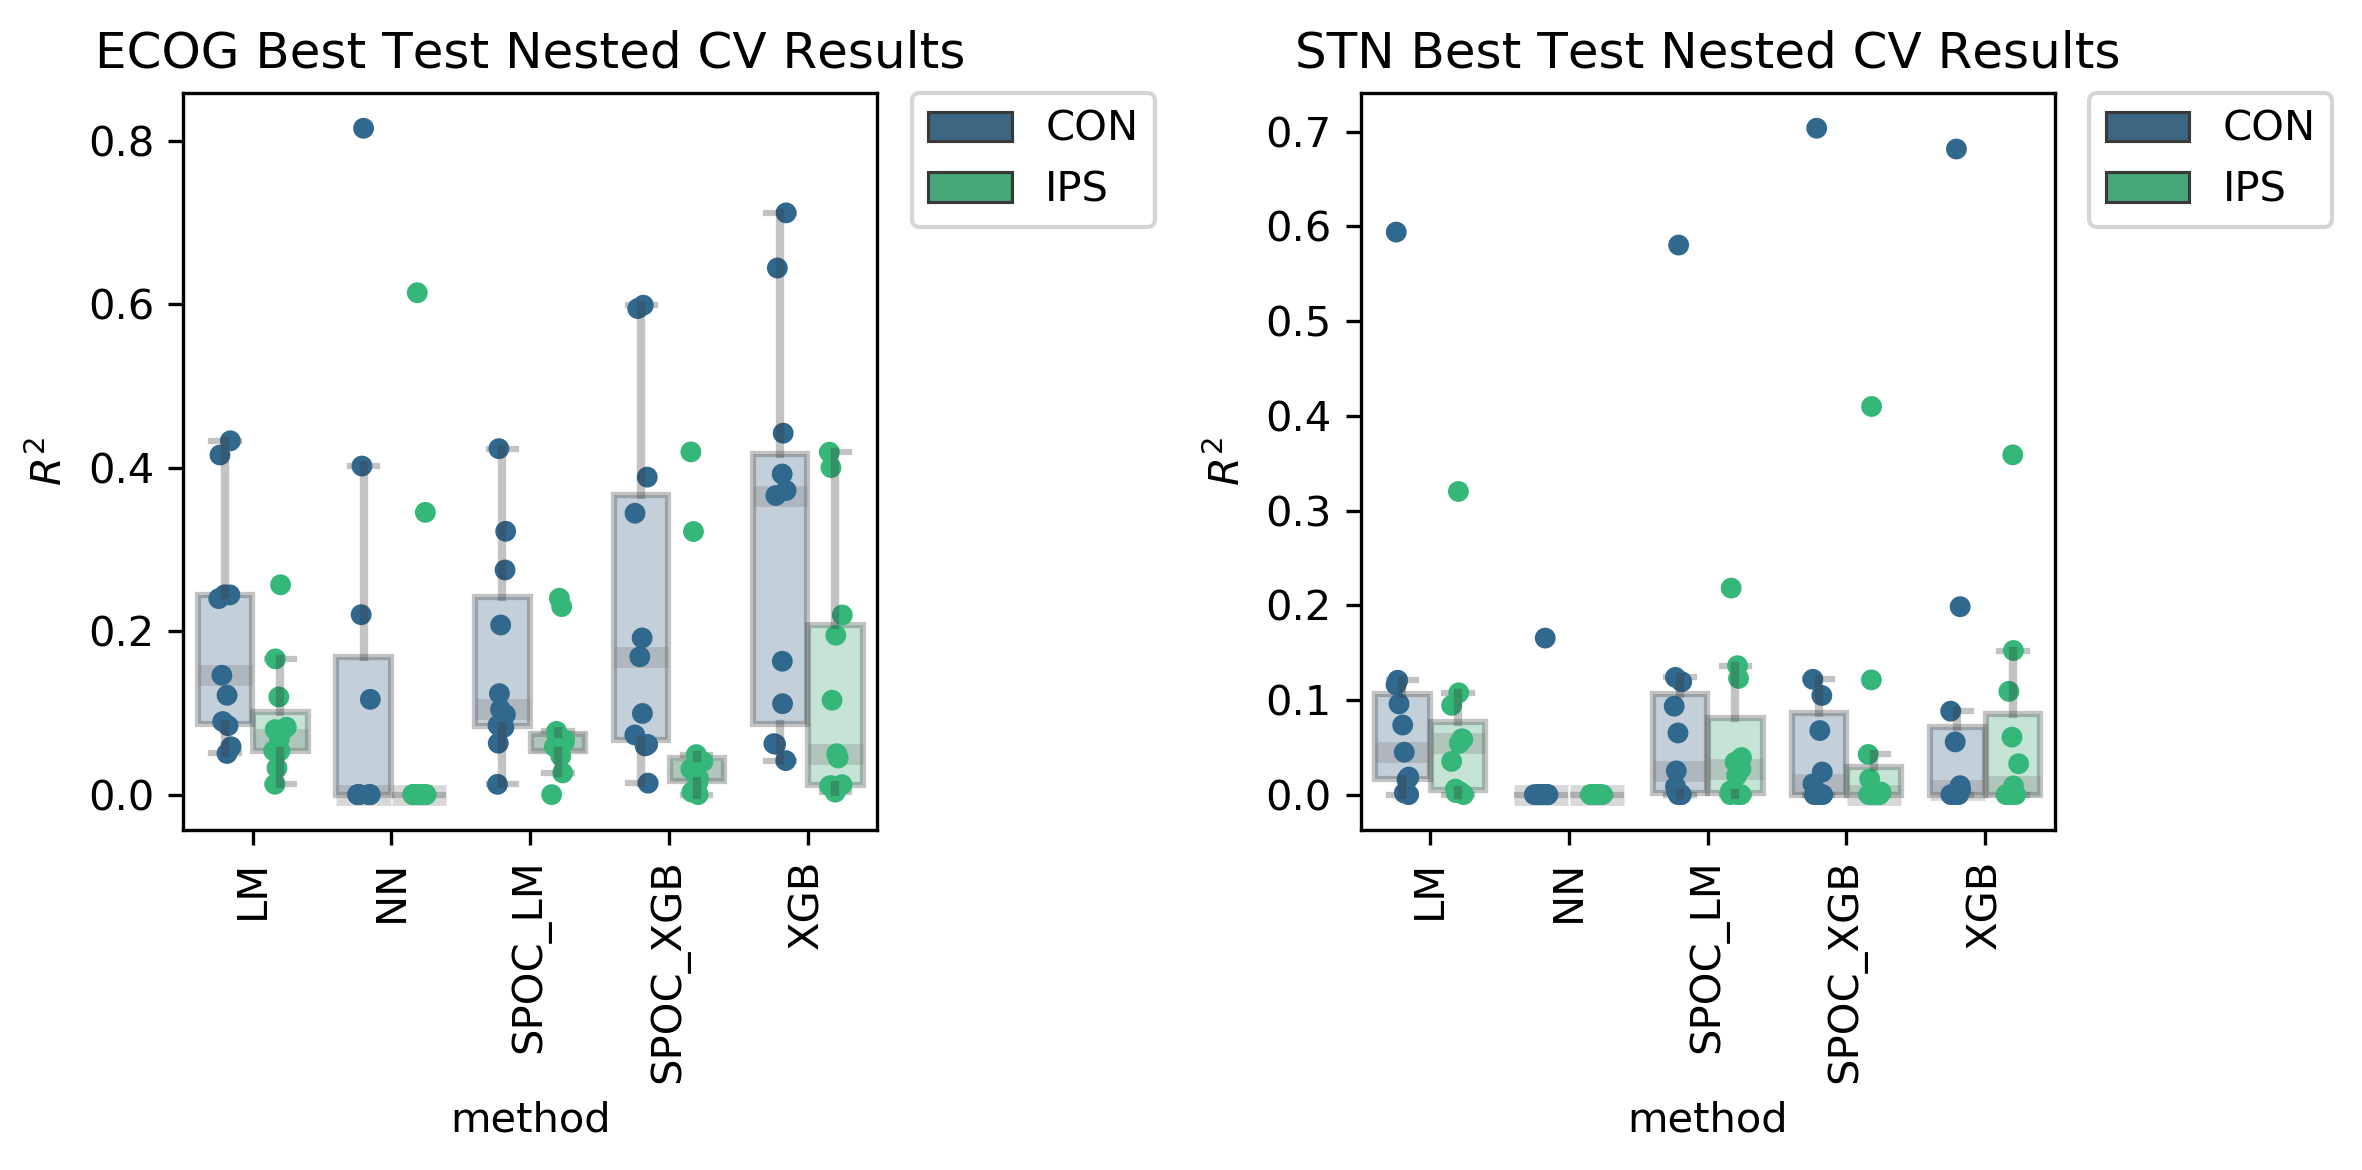

In [27]:
alpha_box = 0.3
plt.figure(figsize=(8,4), dpi=300)
plt.subplot(121)
sb.boxplot(x="method", y=r"$R^2$", hue="lat", order=["LM", "NN", "SPOC_LM", "SPOC_XGB","XGB"], 
           data=df[df["loc"] == "ECOG"], palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=5, color="gray", alpha=alpha_box))

    
ax = sb.stripplot(x="method", y=r"$R^2$", hue="lat", order=["LM", "NN", "SPOC_LM", "SPOC_XGB","XGB"], 
             data=df[df["loc"] == "ECOG"],palette="viridis", dodge=True, s=5)
plt.xticks(rotation=90)

# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("ECOG Best Test Nested CV Results")
plt.subplot(122)
sb.boxplot(x="method", y=r"$R^2$", hue="lat", order=["LM", "NN", "SPOC_LM", "SPOC_XGB","XGB"], 
           data=df[df["loc"] == "STN"], palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=5, color="gray", alpha=alpha_box))
    
ax = sb.stripplot(x="method", y=r"$R^2$", hue="lat", order=["LM", "NN", "SPOC_LM", "SPOC_XGB","XGB"], 
             data=df[df["loc"] == "STN"],palette="viridis", dodge=True, s=5)


# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("STN Best Test Nested CV Results")

plt.tight_layout()
plt.xticks(rotation=90)

C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator ElasticNet from version 0.23.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


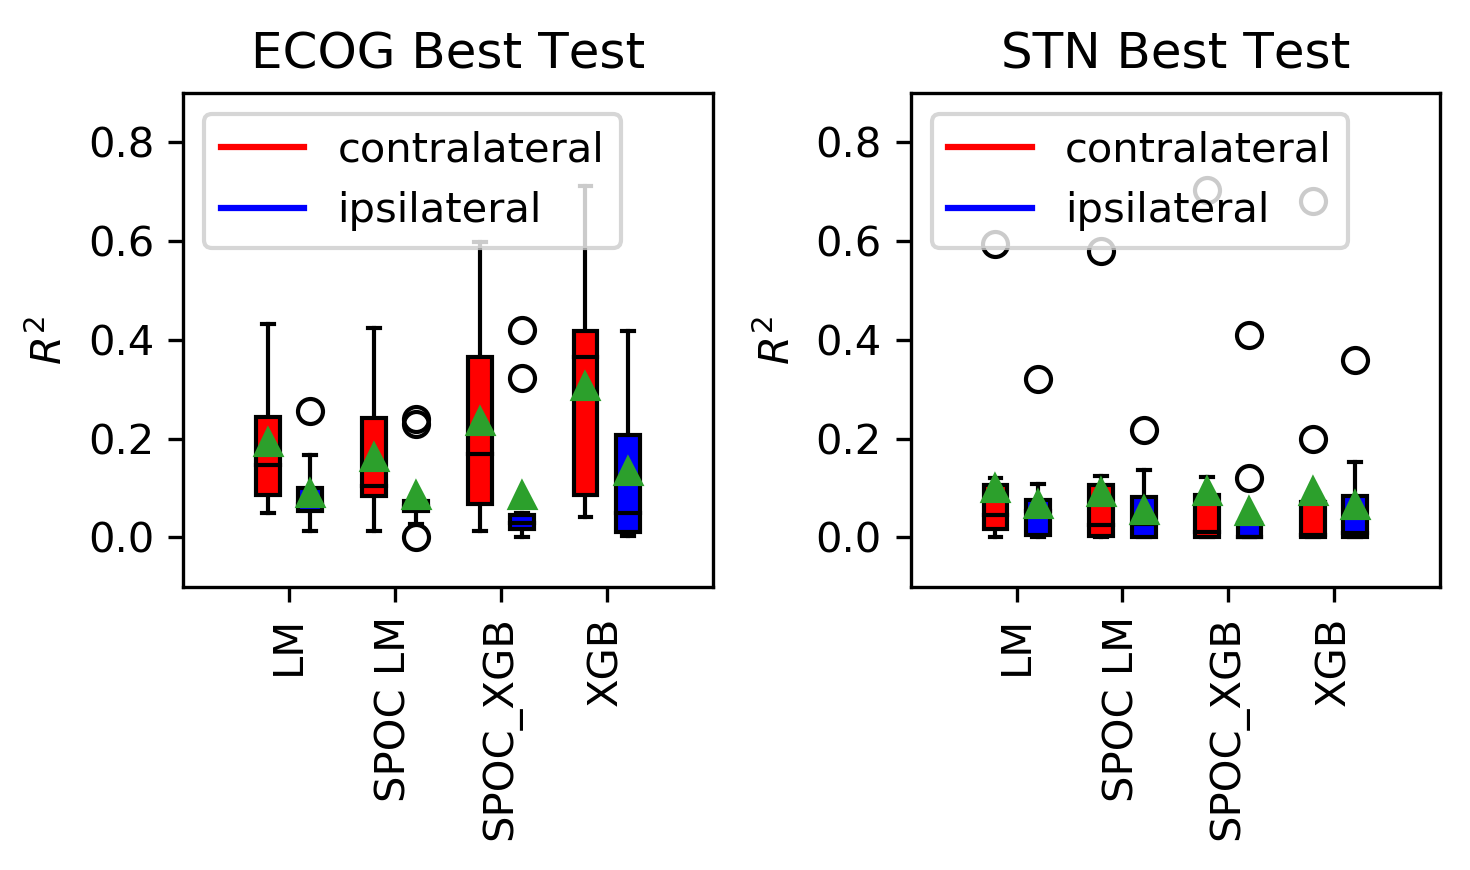

In [6]:

plt.figure(figsize=(5,3), dpi=300)
plt.subplot(121)
plt.title('ECOG Best Test')
my_box_plot_comparison_here([res_LM["ECOG_CON"], res_SPOC_LM["ECOG_CON"], res_SPOC_XGB["ECOG_CON"], res_XGB["ECOG_CON"]], \
                            [res_LM["ECOG_IPS"], res_SPOC_LM["ECOG_IPS"], res_SPOC_XGB["ECOG_IPS"], res_XGB["ECOG_IPS"]], \
                            label_1='contralateral', label_2='ipsilateral')

plt.subplot(122)
plt.title('STN Best Test')
my_box_plot_comparison_here([res_LM["STN_CON"], res_SPOC_LM["STN_CON"], res_SPOC_XGB["STN_CON"], res_XGB["STN_CON"]], \
                            [res_LM["STN_IPS"], res_SPOC_LM["STN_IPS"], res_SPOC_XGB["STN_IPS"], res_XGB["STN_IPS"]], \
                            label_1='contralateral', label_2='ipsilateral')
plt.ylabel(r'$R^2$')
plt.tight_layout()

### Comparison ECOGvsSTN

In [31]:
def my_box_plot_comparison(data_a, data_b, num_ =4, label_1 ='raw channel', label_2 ='grid'):
    ticks = [str(i) for i in range(num_)]
    bpl = plt.boxplot(data_a, positions=np.array(range(num_))*2.0-0.4, showmeans=True, widths=0.4, patch_artist=True)
    bpr = plt.boxplot(data_b, positions=np.array(range(num_))*2.0+0.4, showmeans=True, widths=0.4, patch_artist=True)
    set_box_color(bpl, 'r') # colors are from http://colorbrewer2.org/
    set_box_color(bpr, 'b')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='r', label=label_1)
    plt.plot([], c='b', label=label_2)

    plt.xlim(-2, len(ticks)*2)
    plt.tight_layout()
    plt.xticks(range(0, len(ticks) * 2, 2), ['ECOG con', 'ECOG ips', 'STN con', 'STN ips'], rotation=45)
    plt.ylabel('AUC')

In [32]:
stats.ttest_rel(np.arctanh(res_XGB["ECOG_CON"]), np.arctanh(res_XGB["STN_CON"]))

Ttest_relResult(statistic=3.4529859759731383, pvalue=0.006195108946999321)

In [33]:
stats.ttest_rel(np.arctanh(res_XGB["ECOG_IPS"]), np.arctanh(res_XGB["STN_IPS"]))

Ttest_relResult(statistic=2.490847999595268, pvalue=0.03194376788819656)

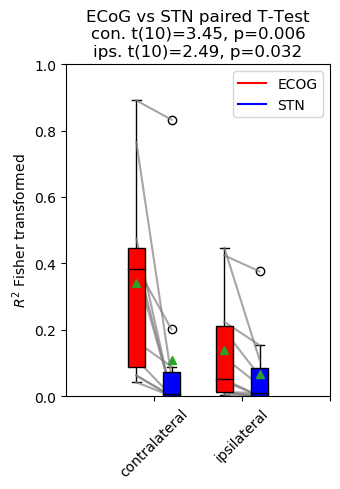

In [34]:
plt.figure(figsize=(3.5,5), dpi=100)
my_box_plot_comparison([np.arctanh(res_XGB["ECOG_CON"]), np.arctanh(res_XGB["ECOG_IPS"])],
    [np.arctanh(res_XGB["STN_CON"]), np.arctanh(res_XGB["STN_IPS"])],num_ =2, \
    label_1 ='ECOG', label_2 ='STN')

#plt.grid(True)
plt.xticks(range(0, 3*2, 2), ['contralateral', 'ipsilateral'], rotation=45)
plt.legend()
plt.title('ECoG vs STN paired T-Test\ncon. t(10)=3.45, p=0.006\nips. t(10)=2.49, p=0.032')
plt.ylim(0, 1)
plt.ylabel('$R^2$'+' Fisher transformed')
plt.tight_layout()
plt.plot([-0.4,0.4],np.array([np.arctanh(res_XGB["ECOG_CON"]), np.arctanh(res_XGB["STN_CON"])]), color='gray', alpha=0.7)
plt.plot([1.6,2.4],np.array([np.arctanh(res_XGB["ECOG_IPS"]), np.arctanh(res_XGB["STN_IPS"])]), color='gray', alpha=0.7)
plt.show()


In [55]:
df_res = pd.DataFrame(np.round(np.array([res_XGB["ECOG_CON"], res_XGB["ECOG_IPS"], 
                                         res_XGB["STN_CON"], res_XGB["STN_IPS"]]).T,2))
df_res.columns = ["ECOG CON", "ECOG IPS", "STN CON", "STN IPS"]

In [61]:
df_res.to_excel("paper_ressults_table_XGB.xlsx")

In [60]:
df_res

,ECOG CON,ECOG IPS,STN CON,STN IPS
0,0.71,0.42,0.68,0.11
1,0.64,0.22,0.06,0.15
2,0.16,0.40,0.09,0.36
3,0.37,0.20,0.20,0.06
4,0.37,0.12,0.01,0.03
5,0.04,0.01,0.00,0.01
6,0.44,0.01,0.00,0.00
7,0.06,0.01,0.00,0.00
8,0.39,0.04,0.00,0.00
9,0.11,0.00,0.00,0.00


In [35]:
df

,$R^2$,lat,loc,method,sub
0,0.711734,CON,ECOG,XGB,000
1,0.594713,CON,ECOG,SPOC_XGB,000
2,0.423290,CON,ECOG,SPOC_LM,000
3,0.432851,CON,ECOG,LM,000
4,0.815260,CON,ECOG,NN,000
...,...,...,...,...,...
215,0.000000,IPS,STN,XGB,014
216,0.000000,IPS,STN,SPOC_XGB,014
217,0.000000,IPS,STN,SPOC_LM,014
218,0.000000,IPS,STN,LM,014


In [36]:
df[r"$R^2$"] = np.arctanh(df[r"$R^2$"])

Text(0, 0.5, 'Fisher transformed $R^2$')

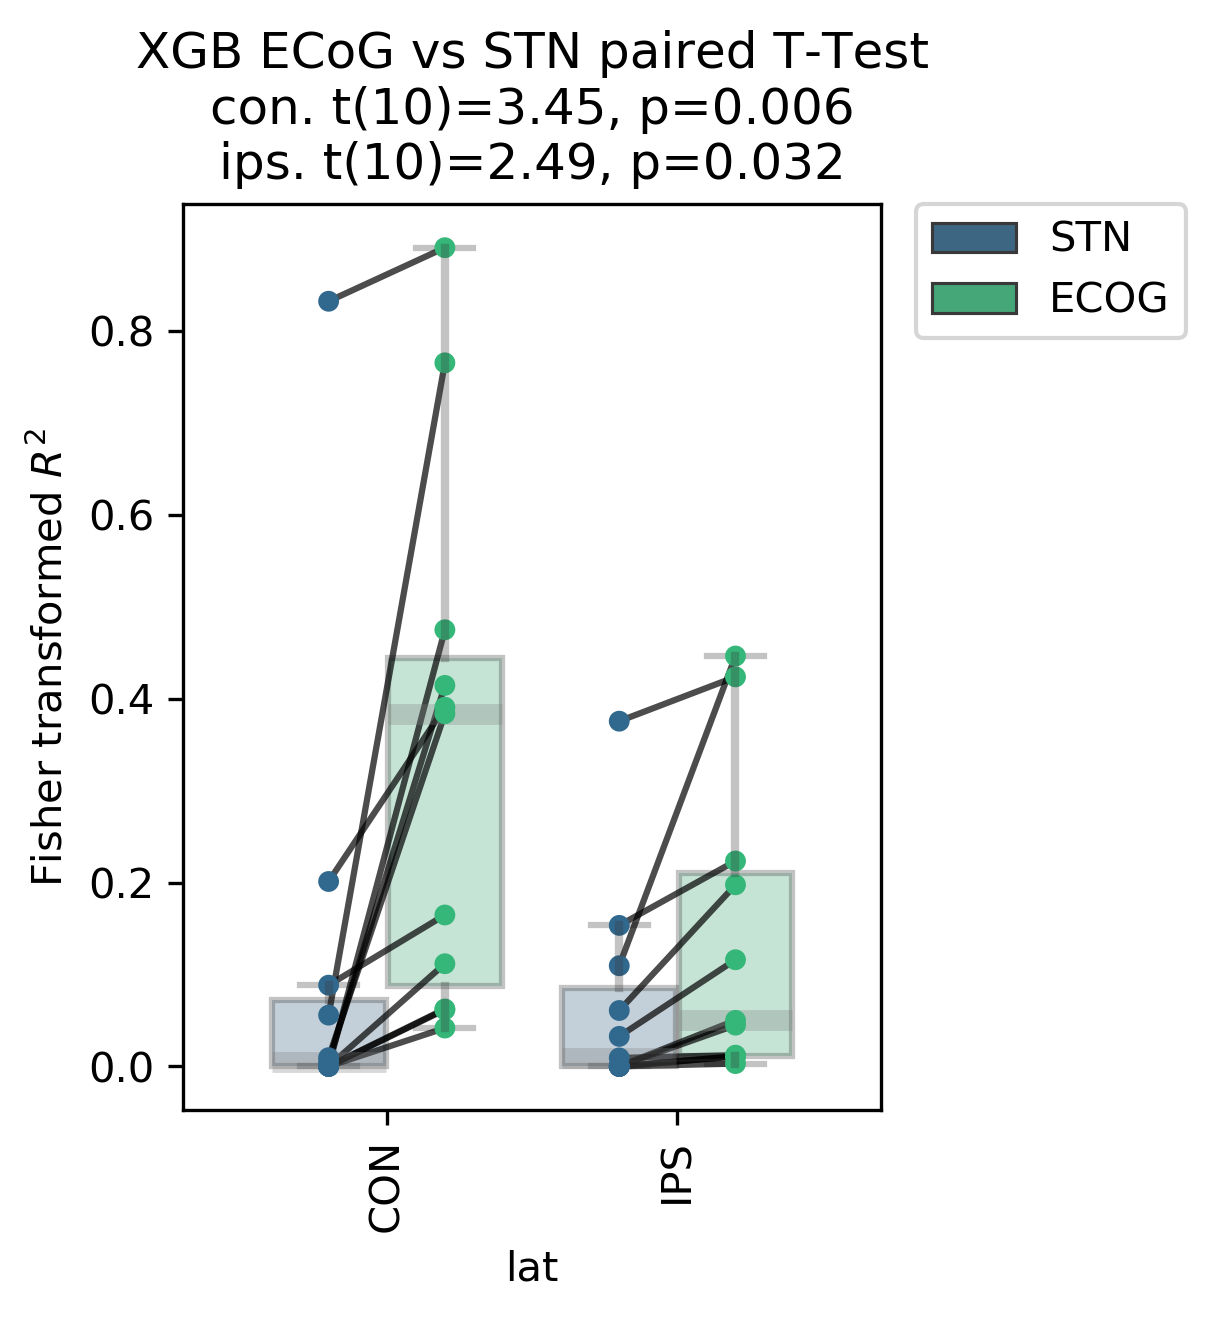

In [37]:
alpha_box = 0.3
plt.figure(figsize=(3,4), dpi=300)
sb.boxplot(x="lat", y=r"$R^2$", hue="loc", order=["CON", "IPS"], hue_order=["STN", "ECOG"],
           data=df[df["method"] == "XGB"], palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=5, color="gray", alpha=alpha_box))

    
ax = sb.stripplot(x="lat", y=r"$R^2$", hue="loc", order=["CON", "IPS"],hue_order=["STN", "ECOG"], 
           data=df[df["method"] == "XGB"],palette="viridis", dodge=True, s=5, jitter=False)
plt.xticks(rotation=90)
plt.plot([-0.2,0.2],np.array([np.arctanh(res_XGB["STN_CON"]), np.arctanh(res_XGB["ECOG_CON"])]), color='black', alpha=0.7)
plt.plot([0.8,1.2],np.array([np.arctanh(res_XGB["STN_IPS"]), np.arctanh(res_XGB["ECOG_IPS"])]), color='black', alpha=0.7)

# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('XGB ECoG vs STN paired T-Test\ncon. t(10)=3.45, p=0.006\nips. t(10)=2.49, p=0.032')
plt.ylabel("Fisher transformed "+r"$R^2$")


### LM test

In [40]:
stats.ttest_rel(np.arctanh(res_LM["ECOG_CON"]), np.arctanh(res_LM["STN_CON"]))

Ttest_relResult(statistic=2.089532269533885, pvalue=0.06317865099944467)

In [41]:
stats.ttest_rel(np.arctanh(res_LM["ECOG_IPS"]), np.arctanh(res_LM["STN_IPS"]))

Ttest_relResult(statistic=1.9708395831709011, pvalue=0.0770368965125709)

Text(0, 0.5, 'Fisher transformed $R^2$')

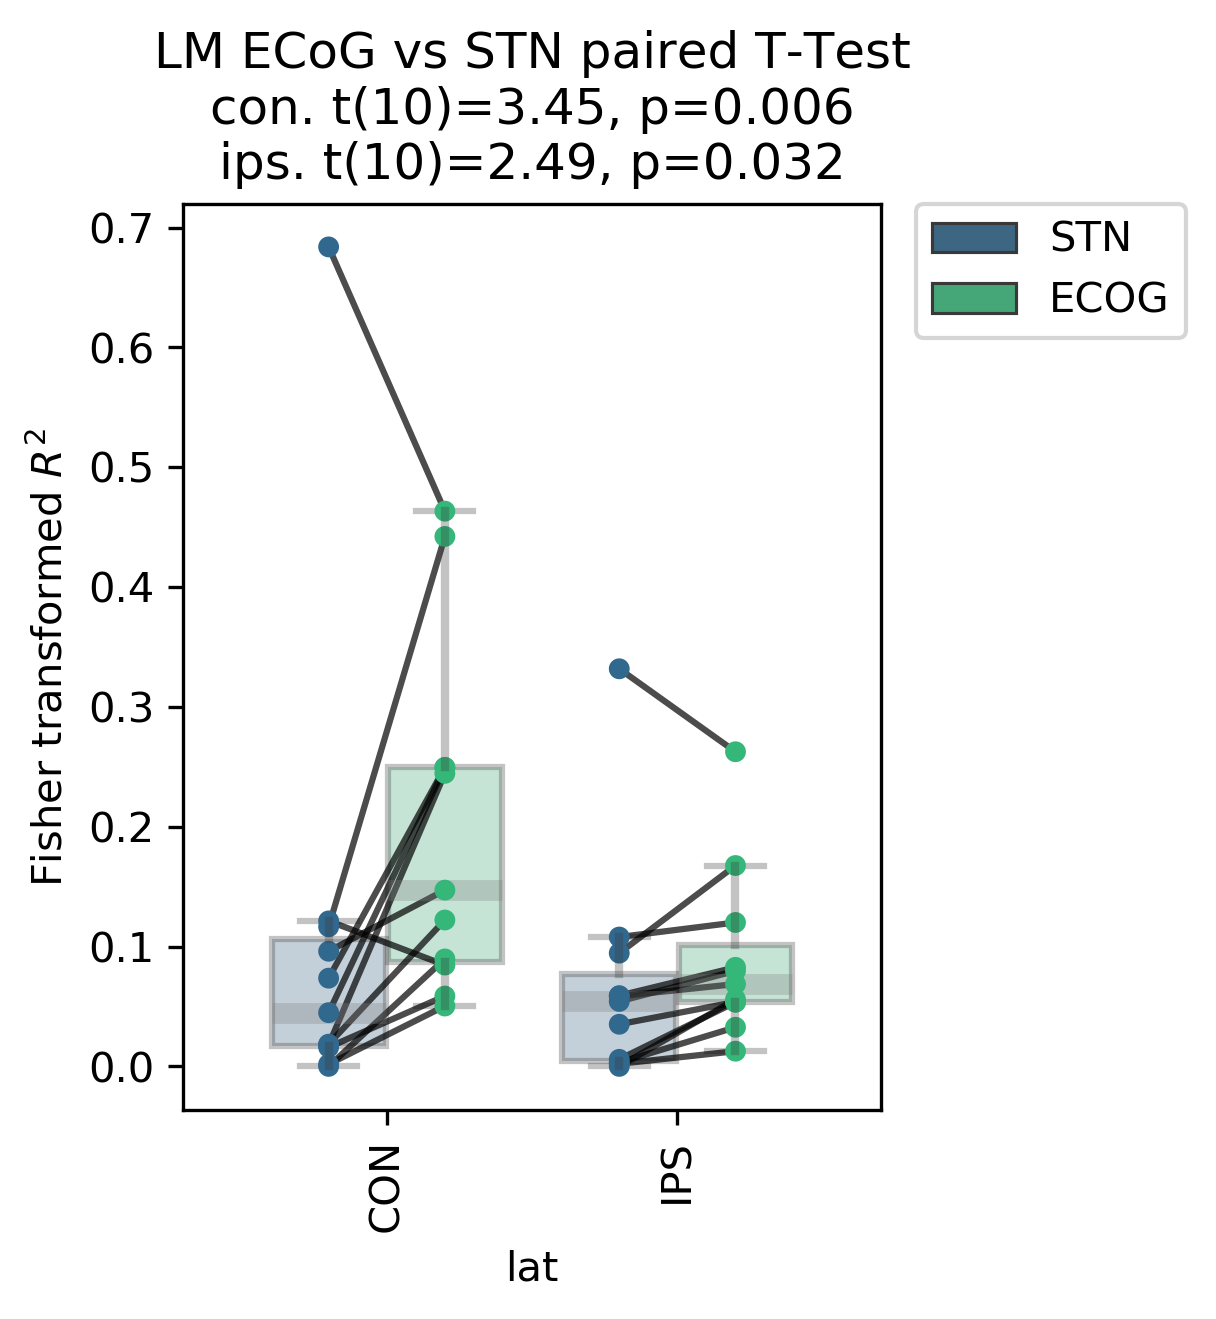

In [39]:
alpha_box = 0.3
plt.figure(figsize=(3,4), dpi=300)
sb.boxplot(x="lat", y=r"$R^2$", hue="loc", order=["CON", "IPS"], hue_order=["STN", "ECOG"],
           data=df[df["method"] == "LM"], palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=5, color="gray", alpha=alpha_box))

    
ax = sb.stripplot(x="lat", y=r"$R^2$", hue="loc", order=["CON", "IPS"],hue_order=["STN", "ECOG"], 
           data=df[df["method"] == "LM"],palette="viridis", dodge=True, s=5, jitter=False)
plt.xticks(rotation=90)
plt.plot([-0.2,0.2],np.array([np.arctanh(res_LM["STN_CON"]), np.arctanh(res_LM["ECOG_CON"])]), color='black', alpha=0.7)
plt.plot([0.8,1.2],np.array([np.arctanh(res_LM["STN_IPS"]), np.arctanh(res_LM["ECOG_IPS"])]), color='black', alpha=0.7)

# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('LM ECoG vs STN paired T-Test\ncon. t(10)=3.45, p=0.006\nips. t(10)=2.49, p=0.032')
plt.ylabel("Fisher transformed "+r"$R^2$")


### insert NN results now

In [6]:
import math

In [7]:
PATH = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\MOVEMENT DATA\\ECoG_STN\\NN_Out_NOCV\\"
patients = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']

In [8]:
res_here = []
for loc in ["ECOG", "STN"]:
    for lat in ["CON", "IPS"]:
        sc_p = []
        for sub in patients:
            sc_ = []
            files = [f for f in os.listdir(PATH) if sub in f and lat in f and loc in f]
            for f in files:
                res = np.load(os.path.join(PATH, f), allow_pickle=True)
                try:
                    if math.isnan(res.tolist()["score_te"]):
                        sc_.append(0)
                    else:
                        sc_.append(res.tolist()["score_te"])
                except:
                    sc_.append(0)
            try:
                sc_p.append(np.max(sc_))
            except:
                sc_p.append(0)
        res_here.append(sc_p)

In [9]:
    
def my_box_plot_comparison_here(data_a, data_b, label_1='contralateral', label_2='ipsilateral'):
    ran = len(data_a)
    ticks = [str(i) for i in range(ran)]
    bpl = plt.boxplot(data_a, positions=np.array(range(ran))*2.0-0.4, showmeans=True, widths=0.45, patch_artist=True)
    bpr = plt.boxplot(data_b, positions=np.array(range(ran))*2.0+0.4, showmeans=True,widths=0.45, patch_artist=True)
    set_box_color(bpl, 'red') # colors are from http://colorbrewer2.org/
    set_box_color(bpr, 'blue')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='red', label=label_1)
    plt.plot([], c='blue', label=label_2)

    plt.xlim(-2, len(ticks)*2)
    plt.tight_layout()
    #plt.xticks(range(0, len(ticks) * 2, 2), ['LM', 'NN', 'SPOC t-lag', 'XGB '+r'$\beta$'+ r'$\gamma$', 'XGB'], rotation=90)
    plt.xticks(range(0, len(ticks) * 2, 2), ['LM', "NN", 'SPOC LM', 'SPOC_XGB','XGB'], rotation=90)
    plt.ylabel(r'$R^2$')
    plt.ylim(-0.1, 0.9)
    plt.legend(loc='upper left')
    

C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator ElasticNet from version 0.23.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


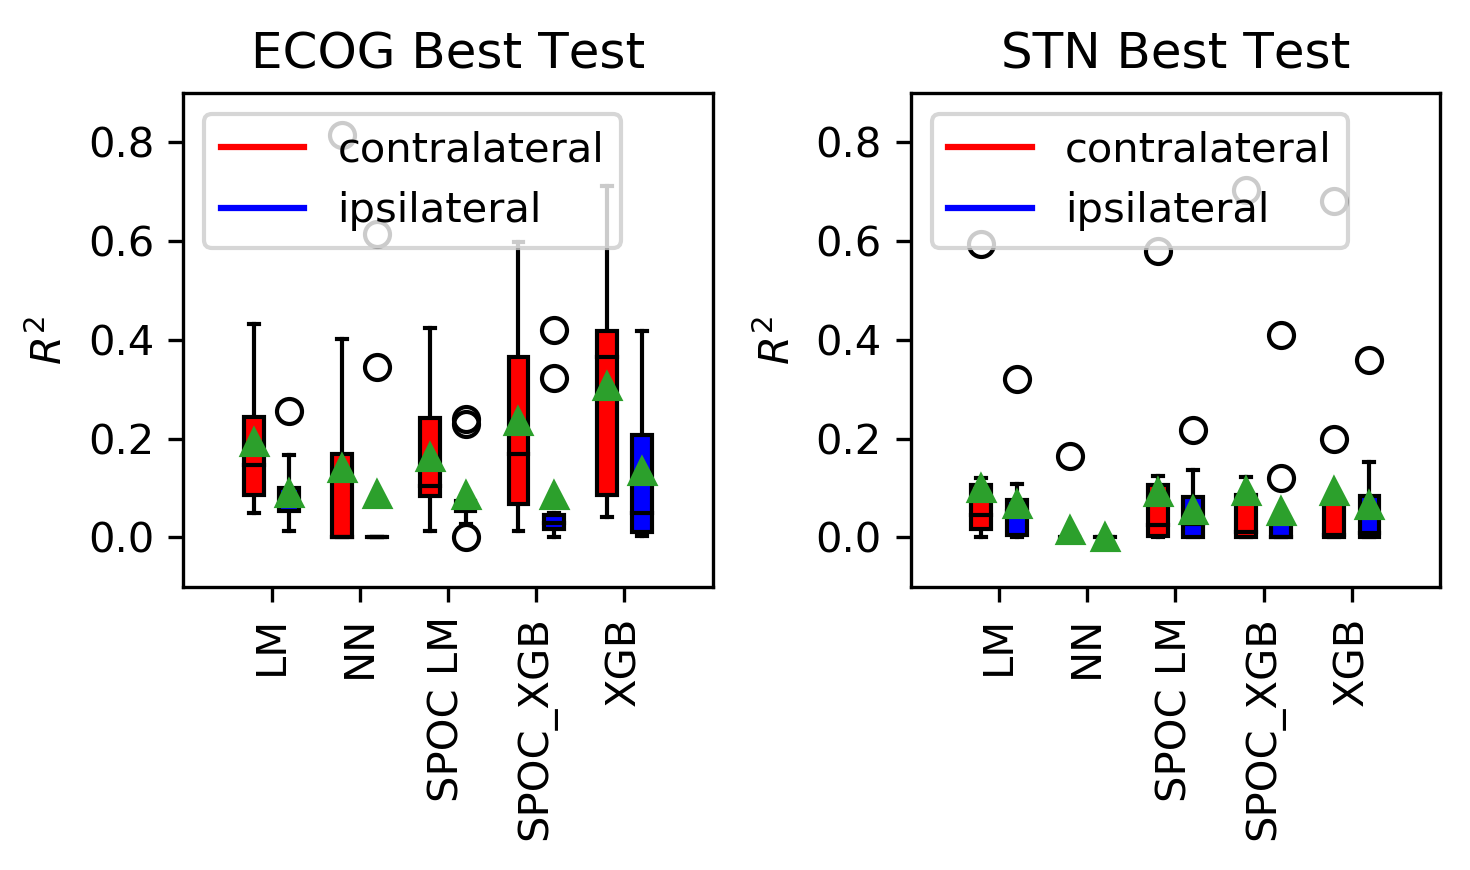

In [10]:
res_XGB =  get_res(os.path.join(PATH_BASE, "XGB_Out"), all_=False, best_Tr=False, log_=False, SPOC_=False)
res_LM =  get_res(os.path.join(PATH_BASE, "LM_Out"), all_=False, best_Tr=False, log_=False, SPOC_=False)
res_SPOC_LM = get_res(os.path.join(PATH_BASE, "LM_Out_SPoC"), all_=False, best_Tr=False, log_=False, SPOC_=True)
res_SPOC_XGB = get_res(os.path.join(PATH_BASE, "XGB_Out_SPoC"), all_=False, best_Tr=False, log_=False, SPOC_=True)

plt.figure(figsize=(5,3), dpi=300)
plt.subplot(121)
plt.title('ECOG Best Test')
my_box_plot_comparison_here([res_LM["ECOG_CON"], res_here[0], res_SPOC_LM["ECOG_CON"], res_SPOC_XGB["ECOG_CON"], res_XGB["ECOG_CON"]], \
                            [res_LM["ECOG_IPS"], res_here[1], res_SPOC_LM["ECOG_IPS"], res_SPOC_XGB["ECOG_IPS"], res_XGB["ECOG_IPS"]], \
                            label_1='contralateral', label_2='ipsilateral')

plt.subplot(122)
plt.title('STN Best Test')
my_box_plot_comparison_here([res_LM["STN_CON"], res_here[2], res_SPOC_LM["STN_CON"], res_SPOC_XGB["STN_CON"], res_XGB["STN_CON"]], \
                            [res_LM["STN_IPS"], res_here[3], res_SPOC_LM["STN_IPS"], res_SPOC_XGB["STN_IPS"], res_XGB["STN_IPS"]], \
                            label_1='contralateral', label_2='ipsilateral')
plt.ylabel(r'$R^2$')
plt.tight_layout()

In [20]:
meas_ = res_XGB["ECOG_CON"]
print(str(np.round(np.mean(meas_),2 ))+ " std: "+ str(np.round(np.std(meas_),2)))
meas_ = res_XGB["STN_CON"]
print(str(np.round(np.mean(meas_),2 ))+ " std: "+ str(np.round(np.std(meas_),2)))
meas_ = res_XGB["ECOG_IPS"]
print(str(np.round(np.mean(meas_),2 ))+ " std: "+ str(np.round(np.std(meas_),2)))
meas_ = res_XGB["STN_IPS"]
print(str(np.round(np.mean(meas_),2 ))+ " std: "+ str(np.round(np.std(meas_),2)))

0.31 std: 0.23
0.09 std: 0.19
0.13 std: 0.15
0.07 std: 0.1


In [21]:
meas_ = res_LM["ECOG_CON"]
print(str(np.round(np.mean(meas_),2 ))+ " std: "+ str(np.round(np.std(meas_),2)))
meas_ = res_LM["STN_CON"]
print(str(np.round(np.mean(meas_),2 ))+ " std: "+ str(np.round(np.std(meas_),2)))
meas_ = res_LM["ECOG_IPS"]
print(str(np.round(np.mean(meas_),2 ))+ " std: "+ str(np.round(np.std(meas_),2)))
meas_ = res_LM["STN_IPS"]
print(str(np.round(np.mean(meas_),2 ))+ " std: "+ str(np.round(np.std(meas_),2)))

0.19 std: 0.13
0.1 std: 0.16
0.09 std: 0.07
0.07 std: 0.09


In [29]:
stats.ttest_rel(np.arctanh(res_XGB["ECOG_CON"]), np.arctanh(res_LM["ECOG_CON"]))

Ttest_relResult(statistic=3.0371894389532432, pvalue=0.012522505834203994)

In [33]:
stats.ttest_rel(np.arctanh(res_XGB["ECOG_CON"]), np.arctanh(res_here[0]))

Ttest_relResult(statistic=2.5190427085970244, pvalue=0.03043723632334427)

In [34]:
meas_ = res_here[0]
print(str(np.round(np.mean(meas_),2 ))+ " std: "+ str(np.round(np.std(meas_),2)))

0.14 std: 0.25


In [37]:
meas_ = res_SPOC_XGB["ECOG_CON"]
print(str(np.round(np.mean(meas_),2 ))+ " std: "+ str(np.round(np.std(meas_),2)))

0.24 std: 0.2


In [36]:
stats.ttest_rel(np.arctanh(res_XGB["ECOG_CON"]), np.arctanh(res_SPOC_LM["ECOG_CON"]))

Ttest_relResult(statistic=3.267729158226033, pvalue=0.008462744682248516)

In [32]:
stats.ttest_rel(np.arctanh(res_XGB["ECOG_CON"]), np.arctanh(res_SPOC_XGB["ECOG_CON"]))

Ttest_relResult(statistic=2.287072201169659, pvalue=0.045238402873960276)

In [30]:
stats.ttest_rel(np.arctanh(res_XGB["ECOG_IPS"]), np.arctanh(res_LM["ECOG_IPS"]))

Ttest_relResult(statistic=1.5993053645258137, pvalue=0.14083614964643376)